# 11章 オブザーバ

In [1]:
from control.matlab import *
import matplotlib.pyplot as plt
import numpy as np

#plt.rcParams['font.family'] ='sans-serif' #使用するフォント
plt.rcParams['font.family'] = 'Times New Roman' # font familyの設定
plt.rcParams['mathtext.fontset'] = 'cm' # math fontの設定
plt.rcParams['xtick.direction'] = 'in' #x軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams['ytick.direction'] = 'in' #y軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams['xtick.major.width'] = 1.0 #x軸主目盛り線の線幅
plt.rcParams['ytick.major.width'] = 1.0 #y軸主目盛り線の線幅
plt.rcParams['font.size'] = 11 #フォントの大きさ
plt.rcParams['axes.linewidth'] = 0.5 # 軸の線幅edge linewidth。囲みの太さ
plt.rcParams['mathtext.default'] = 'it'#'regular'
plt.rcParams['axes.xmargin'] = '0'
plt.rcParams['axes.ymargin'] = '0.05'
plt.rcParams['savefig.facecolor'] = 'None'
plt.rcParams['savefig.edgecolor'] = 'None'

plt.rcParams["legend.fancybox"] = True     # 丸角
# plt.rcParams["legend.framealpha"] = 1    # 透明度の指定、0で塗りつぶしなし
# plt.rcParams["legend.edgecolor"] = 'gray' # edgeの色を変更
plt.rcParams["legend.handlelength"] = 1.8  # 凡例の線の長さを調節
plt.rcParams["legend.labelspacing"] = 0.4  # 垂直方向（縦）の距離の各凡例の距離
plt.rcParams["legend.handletextpad"] = 0.7 # 凡例の線と文字の距離の長さ
plt.rcParams["legend.markerscale"] = 1.0   # 点がある場合のmarker scale

In [2]:
def linestyle_generator():
    linestyle = ['-', '--', '-.', ':']
    lineID = 0
    while True:
        yield linestyle[lineID]
        lineID = (lineID + 1) % len(linestyle)

In [3]:
def plot_set(fig_ax, *args):
    fig_ax.set_xlabel(args[0])
    fig_ax.set_ylabel(args[1])
    fig_ax.grid(ls=':', lw=0.5)
    if len(args)==3:
        fig_ax.legend(loc=args[2])

In [4]:
def bodeplot_set(fig_ax, *args):
    fig_ax[0].grid(which="both", ls=':', lw=0.5)
    fig_ax[0].set_ylabel('Gain [dB]')

    fig_ax[1].grid(which="both", ls=':', lw=0.5)
    fig_ax[1].set_xlabel('$\omega$ [rad/s]')
    fig_ax[1].set_ylabel('Phase [deg]')
    
    if len(args) > 0:
        fig_ax[1].legend(loc=args[0])
    if len(args) > 1:
        fig_ax[0].legend(loc=args[1])

## オブザーバ


In [5]:
# 安定なシステム
A = '0 1; -2 -3'
B = '0; 1'
C = '1 0 ; 0 1'
D = '0; 0'
P = ss(A, B, C, D)
print(P.pole())

C1 = np.matrix([1,0])

[-1. -2.]


### 例11.1: 同一次元オブザーバ

In [6]:
# オブザーバ極
observer_poles=[-8+2j,-8-2j]

# オブザーバゲインの設計（状態フィードバックの双対） 
L = -acker(P.A.T, C1.T, observer_poles).T
print(L)

[[-13.]
 [-27.]]


In [7]:
np.linalg.eigvals(P.A + L * C1)

array([-8.+2.j, -8.-2.j])

In [8]:
Gsf = ss(P.A, P.B, np.eye(2), [[0],[0]])
Obs = ss(P.A + L*C1, np.c_[P.B, -L], np.eye(2), [[0,0],[0,0]] )

In [9]:
pole(Obs)

array([-8.+2.j, -8.-2.j])

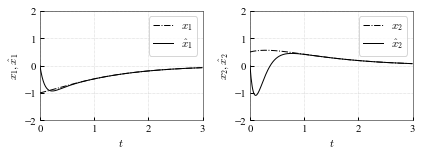

In [10]:
fig, ax = plt.subplots(1,2, figsize=(6, 2.3))

T = np.arange(0, 3, 0.01)
X0 = [-1, 0.5]
x, t = initial(Gsf, T, X0)
ax[0].plot(t, x[:, 0], ls='-.', label='${x}_1$', c='k', lw=1)
ax[1].plot(t, x[:, 1], ls='-.', label='${x}_2$', c='k', lw=1)

# 入力 u = Fx
# u = [ [F[0,0]*x[i,0]+F[0,1]*x[i,1]] for i in range(len(x))]

u = 0*(T>0)
# 出力 y = Cx
y = x[:, 0]
# オブザーバで推定した状態の振る舞い
xhat, t, x0 = lsim(Obs, np.c_[u, y], T, [0, 0])
ax[0].plot(t, xhat[:, 0], label='$\hat{x}_1$', c='k', lw=1)
ax[1].plot(t, xhat[:, 1], label='$\hat{x}_2$', c='k', lw=1)

for i in [0, 1]:
    plot_set(ax[i], '$t$', '', 'best')
    ax[i].set_xlim([0, 3])

ax[0].set_ylim([-2, 2])
ax[0].set_ylabel('$x_1, \hat{x}_1$')
ax[1].set_ylabel('$x_2, \hat{x}_2$')
ax[1].set_ylim([-2, 2])

fig.tight_layout()
#fig.savefig("ex_obs.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

### コーヒーブレーク: 外乱オブザーバ

上記の同一次元オブザーバでは，外乱の影響をうける

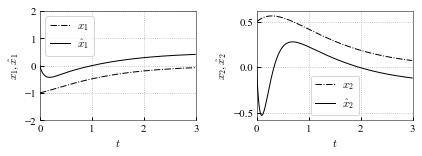

In [11]:
fig, ax = plt.subplots(1,2, figsize=(6, 2.3))

Td = np.arange(0, 3, 0.01)
X0 = [-1, 0.5]
d = 0.5*(T>0)

x, t = initial(Gsf, Td, X0)
ax[0].plot(t, x[:, 0], ls='-.', label='${x}_1$', c='k', lw=1)
ax[1].plot(t, x[:, 1], ls='-.', label='${x}_2$', c='k', lw=1)

# 入力 
u = 0*(Td>0)
# 出力 y = Cx+d
y = x[:, 0]+d

xhat, t, x0 = lsim(Obs, np.c_[u, y], T, [0, 0])
ax[0].plot(t, xhat[:, 0], label='$\hat{x}_1$', c='k', lw=1)
ax[1].plot(t, xhat[:, 1], label='$\hat{x}_2$', c='k', lw=1)

for i in [0, 1]:
    ax[i].grid(ls=':')
    ax[i].set_xlim([0, 3])
    ax[i].set_xlabel('$t$')
    ax[i].legend()

ax[0].set_ylim([-2, 2])
ax[0].set_ylabel('$x_1, \hat{x}_1$')
ax[1].set_ylabel('$x_2, \hat{x}_2$')
#ax[1].set_ylim([-2, 2])

fig.tight_layout()
#fig.savefig("dis_obs.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

外乱を推定する

In [12]:
# オブザーバ極
observer_poles=[-8+2j,-8-2j, -3] 

# オブザーバゲインの設計（状態フィードバックの双対）
E = [[0], [0]]
Abar = np.r_[ np.c_[P.A, E], np.zeros((1,3))] 
Bbar = np.c_[ P.B.T, np.zeros((1,1)) ].T
Cbar = np.c_[ C1, 1 ]

Lbar = -acker(Abar.T, Cbar.T, observer_poles).T
print(Lbar)

# Obs = ss(Abar+Bbar*Fbar+Lbar*Cbar, -Lbar, np.eye(3), [[0],[0],[0]] )
Aob = Abar + Lbar*Cbar
Bob = np.c_[Bbar, -Lbar]
Obs = ss(Aob, Bob, np.eye(3), [[0,0],[0,0],[0,0]] )

[[  86.]
 [ -66.]
 [-102.]]


(-0.5, 1.0)

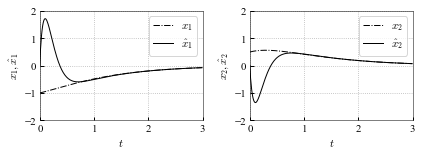

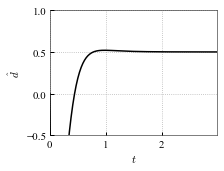

In [13]:
fig, ax = plt.subplots(1,2, figsize=(6, 2.3))

Td = np.arange(0, 3, 0.01)
X0 = [-1, 0.5]
d = 0.5*(T>0)
x, t = initial(Gsf, Td, X0)
ax[0].plot(t, x[:, 0], ls='-.', label='${x}_1$', c='k', lw=1)
ax[1].plot(t, x[:, 1], ls='-.', label='${x}_2$', c='k', lw=1)


# 入力 
u = 0*(Td>0)
# 出力 y = Cx+d
y = x[:, 0]+d
xhat, t, x0 = lsim(Obs, np.c_[u, y], T, [0, 0, 0])
#xhat, t, x0 = lsim(Obs, x[:, 0]+d, T, [0, 0, 0])
ax[0].plot(t, xhat[:, 0], label='$\hat{x}_1$', c='k', lw=1)
ax[1].plot(t, xhat[:, 1], label='$\hat{x}_2$', c='k', lw=1)

for i in [0, 1]:
    ax[i].grid(ls=':')
    ax[i].set_xlim([0, 3])
    ax[i].set_xlabel('$t$')
    ax[i].legend()

ax[0].set_ylim([-2, 2])
ax[0].set_ylabel('$x_1, \hat{x}_1$')
ax[1].set_ylabel('$x_2, \hat{x}_2$')
ax[1].set_ylim([-2, 2])

fig.tight_layout()
# fig.savefig("dis_obs2.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

fig, ax = plt.subplots(figsize=(3, 2.3))
ax.plot(t, xhat[:, 2], label='$\hat{x}_2$', color='k')
ax.grid(ls=':')
ax.set_xlabel('$t$')
ax.set_ylabel('$\hat{d}$')
ax.set_ylim([-0.5, 1])

### 例11.2: 併合系

In [14]:
# レギュレータ極
regulator_poles = [-3+3j, -3-3j]
# 極配置
F = -acker(P.A, P.B, regulator_poles)
print(F)

[[-16.  -3.]]


In [15]:
Gsf = ss(P.A + P.B*F, P.B, np.eye(2), [[0],[0]])

In [16]:
# オブザーバ極
observer_poles=[-8+2j,-8-2j]
# オブザーバゲインの設計（状態フィードバックの双対） 
L = -acker(P.A.T, C1.T, observer_poles).T

In [17]:
Aob1 = np.c_[P.A, P.B@F]
Aob2 = np.c_[-L@C1, P.A+L@C1+P.B@F]
Aob = np.r_[Aob1, Aob2]
Bob = np.zeros([4,1])
Cob = [[ 1, 0 ,0 ,0 ], [0, 1, 0, 0]]
Dob = np.zeros([2,1])
Gobsf = ss(Aob, Bob, Cob, Dob)

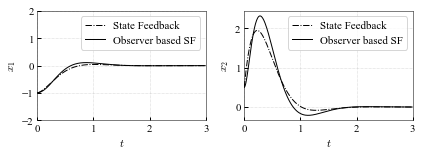

In [18]:
fig, ax = plt.subplots(1,2, figsize=(6, 2.3))

T = np.arange(0, 3, 0.01)
X0 = [-1, 0.5]
x, t = initial(Gsf, T, X0)
ax[0].plot(t, x[:, 0], ls='-.', label='State Feedback', c='k', lw=1)
ax[1].plot(t, x[:, 1], ls='-.', label='State Feedback', c='k', lw=1)

# オブザーバベースコントローラ
xhat, t = initial(Gobsf, T, [X0[0], X0[1], 0, 0] )
ax[0].plot(t, xhat[:, 0], label='Observer based SF', c='k', lw=1)
ax[1].plot(t, xhat[:, 1], label='Observer based SF', c='k', lw=1)

for i in [0, 1]:
    plot_set(ax[i], '$t$', '', 'best')
    ax[i].set_xlim([0, 3])

ax[0].set_ylim([-2, 2])
ax[0].set_ylabel('$x_1$')
ax[1].set_ylabel('$x_2$')

fig.tight_layout()
#fig.savefig("obs_base_control.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

### 例11.3: 最小次元オブザーバ

In [19]:
A = '0 1; -2 -3'
B = '0; 1'
C = '1 0 ; 0 1'
D = '0; 0'
P = ss(A, B, C, D)
print(P.pole())
C1 = np.matrix([1,0])

[-1. -2.]


In [20]:
A11 = P.A[0,0]
A12 = P.A[0,1]
A21 = P.A[1,0]
A22 = P.A[1,1]
B1 = P.B[0]
B2 = P.B[1]

In [21]:
A11

0.0

In [22]:
obs_pole = -8
L = (obs_pole-A22)/A12
Obs = ss(A22+L*A12, np.c_[B2+L*B1, A21-A22*L+L*(A11-A12*L)], 1, np.c_[0, -L] )
print(Obs)

A = [[-8.]]

B = [[  1. -42.]]

C = [[1.]]

D = [[0. 5.]]



In [23]:
L

-5.0

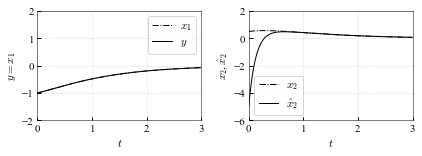

In [24]:
Gsf = ss(P.A, P.B, np.eye(2), [[0],[0]])

fig, ax = plt.subplots(1,2, figsize=(6, 2.3))

T = np.arange(0, 3, 0.01)
X0 = [-1, 0.5]
x, t = initial(Gsf, T, X0)
ax[0].plot(t, x[:, 0], ls='-.', label='${x}_1$', c='k', lw=1)
ax[1].plot(t, x[:, 1], ls='-.', label='${x}_2$', c='k', lw=1)

# 入力 u = Fx
# u = [ [F[0,0]*x[i,0]+F[0,1]*x[i,1]] for i in range(len(x))]
u = 0*(T>0)
# 出力 y = Cx
y = x[:, 0]
# オブザーバで推定した状態の振る舞い
xhat, t, x0 = lsim(Obs, np.c_[u, y], T, [0])
ax[0].plot(t, y, label='$y$', c='k', lw=1)
ax[1].plot(t, xhat, label='$\hat{x}_2$', c='k', lw=1)

for i in [0, 1]:
    plot_set(ax[i], '$t$', '', 'best')
    ax[i].set_xlim([0, 3])

ax[0].set_ylim([-2, 2])
ax[0].set_ylabel('$y=x_1$')
ax[1].set_ylabel('$x_2, \hat{x}_2$')
ax[1].set_ylim([-6, 2])

fig.tight_layout()
#fig.savefig("ex_minimal_obs.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

### 例11.4: 線形関数オブザーバ

In [25]:
E = -5
G = -1
W = -22
V = 3
H = 12
Obs = ss(E, H, V, W )
print(Obs)

A = [[-5.]]

B = [[12.]]

C = [[3.]]

D = [[-22.]]



In [26]:
F

matrix([[-16.,  -3.]])

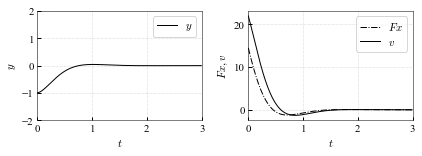

In [27]:
Gsf = ss(P.A + P.B*F, P.B, np.eye(2), [[0],[0]])

fig, ax = plt.subplots(1,2, figsize=(6, 2.3))

T = np.arange(0, 3, 0.01)
X0 = [-1, 0.5]
x, t = initial(Gsf, T, X0)
#ax[0].plot(t, x[:, 0], ls='-.', label='${x}_1$', c='k')
#ax[1].plot(t, x[:, 1], ls='-.', label='${x}_2$', c='k')

# 入力 u = Fx
u = [ [F[0,0]*x[i,0]+F[0,1]*x[i,1]] for i in range(len(x))]
# u = 0*(T>d)
ax[1].plot(t, u, ls='-.', label='$Fx$', c='k', lw=1)

# 出力 y = Cx
y = x[:, 0]
# オブザーバで推定した状態の振る舞い
#xhat, t, x0 = lsim(Obs, np.c_[u, y], T, [0])
xhat, t, x0 = lsim(Obs, y, T, [0])
ax[0].plot(t, y, label='$y$', c='k', lw=1)
ax[1].plot(t, xhat, label='$v$', c='k', lw=1)

for i in [0, 1]:
    plot_set(ax[i], '$t$', '', 'best')
    ax[i].set_xlim([0, 3])

ax[0].set_ylim([-2, 2])
ax[0].set_ylabel('$y$')
ax[1].set_ylabel('$Fx,v$')

fig.tight_layout()
# fig.savefig("ex_linfunc_obs.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

### 例11.5: カルマンフィルタ

In [28]:
A = '0 1; -2 -3'
B = '0; 1'
C = '1 0 ; 0 1'
D = '0; 0'
P = ss(A, B, C, D)
print(P.pole())
C1 = np.matrix([1,0])

[-1. -2.]


In [29]:
QN = 1
RN = 1
L, X, _ = lqe(P.A, P.B, C1, QN, RN)
L = -L
print(L)

[[-0.07768354]
 [-0.00301737]]


0.9710980760898553
0.027545156261989744
[[-0.07768354]
 [-0.00301737]]


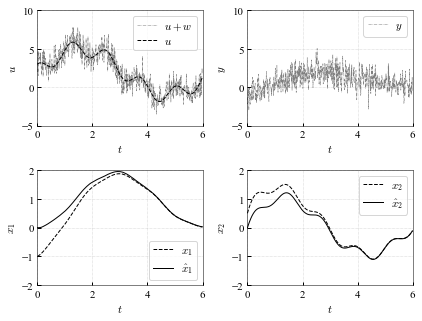

In [30]:
fig, ax = plt.subplots(2,2, figsize=(6, 4.6))

T = np.arange(0, 6, 0.01)
u = 3*np.sin(1*T)+np.cos(5*T)+2

QN = 1
RN = 1
w = np.random.normal(loc=0, scale=np.sqrt(QN), size=len(T))
v = np.random.normal(loc=0, scale=np.sqrt(RN), size=len(T))

print(np.var(w))
print(np.mean(w))

L, _, _ = lqe(P.A, P.B, C1, QN, RN)
L = -L
print(L)
#L = np.matrix([[-10], [-10]])
Obs = ss(P.A + L*C1, np.c_[P.B, -L], np.eye(2), [[0,0],[0,0]] )

X0 = [-1, 0.5]
x, t, _= lsim(P, u+w, T, X0)

xorg, t, _= lsim(P, u, T, X0)

# 出力 y = Cx
y = x[:, 0]+v

ax[0,1].plot(t, y,   ls='-.', label='$y$', c='gray', lw=0.5)
ax[1,0].plot(t, xorg[:,0],   ls='--', label='$x_1$', c='k', lw=1)
ax[1,1].plot(t, xorg[:,1],   ls='--', label='$x_2$', c='k', lw=1)
ax[0,0].plot(t, u+w, ls='-.', label='$u+w$', c='gray', lw=0.5)

# 入力 u = Fx
#u = [ [F[0,0]*x[i,0]+F[0,1]*x[i,1]] for i in range(len(x))]
#u = np.sin(T)
#u = 0*(T>0)

# オブザーバで推定した状態の振る舞い
xhat, t, x0 = lsim(Obs, np.c_[u, y], T, [0, 0])
ax[1,0].plot(t, xhat[:, 0], label='$\hat{x}_1$', c='k', lw=1)
ax[1,1].plot(t, xhat[:, 1], label='$\hat{x}_2$', c='k', lw=1)
ax[0,0].plot(t, u, label='$u$', c='k', ls='--',lw=1)

for i in [0, 1]:
    for j in [0, 1]:
        plot_set(ax[i,j], '$t$', '', 'best')
        ax[i,j].set_xlim([0, 6])

ax[0,1].set_ylim([-5, 10])
ax[0,1].set_ylabel('$y$')
ax[0,0].set_ylabel('$u$')
ax[0,0].set_ylim([-5, 10])
ax[1,0].set_ylim([-2, 2])
ax[1,0].set_ylabel('$x_1$')
ax[1,1].set_ylim([-2, 2])
ax[1,1].set_ylabel('$x_2$')


fig.tight_layout()
# fig.savefig("ex_kalman.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

## 章末問題

In [31]:
# 章末問題1
A = [[0, 1],[-3, -4]]
B = [[0],[1]]
C = [1,0]
P = ss(A,B,C,0)

L = -acker(P.A.T,P.C.T, [-4, -4]).T
L

matrix([[-4.],
        [ 3.]])

In [32]:
# 章末問題2
A = [[0, 1],[0, 0]]
B = [[1],[1]]
C = [1,0]
P = ss(A,B,C,0)

B2 = np.matrix([[0], [1]])

# オブザーバ極
observer_poles=[-3,-3, -3] 

# オブザーバゲインの設計（状態フィードバックの双対）
Abar = np.r_[ np.c_[P.A, B2], np.zeros((1,3))] 
Bbar = np.c_[ P.B.T, np.zeros((1,1)) ].T
Cbar = np.c_[ P.C, 0 ]

Lbar = -acker(Abar.T, Cbar.T, observer_poles).T
print(Lbar)

[[ -9.]
 [-27.]
 [-27.]]


In [33]:
# 章末問題3
A = [[0,1],[0,0]]
B = [[0],[1]]
C = [1,0]
P = ss(A,B,C,0)

L = -acker(P.A.T,P.C.T,[-3+3j, -3-3j]).T
F = -acker(P.A, P.B, [-1+1j, -1-1j])

In [34]:
G = ss(A+B*F+L*C, L, -F, 0)
tf(G)

TransferFunction(array([-48., -36.]), array([ 1.,  8., 32.]))

In [35]:
# 章末問題4
A = [[0,1],[0,0]]
B = [[0],[1]]
C = [1,0]
P = ss(A,B,C,0)

In [36]:
F = -acker(P.A, P.B, [-3+3j, -3-3j])
F

matrix([[-18.,  -6.]])

In [37]:
A11 = 0
A12 = 1
A21 = 0
A22 = 0
B1 = 0
B2 = 1

f1 = -18
f2 = -6
pole = -5
L = ((pole)-A22)/A12

Ak = A22+L*A12+(B2+L*B1)*f2
Bk = -Ak*L+A21+L*A11+(B2+L*B1)*f1
Ck = f2
Dk = f1-f2*L

K = ss(Ak,Bk,Ck,Dk)
K

StateSpace(array([[-11.]]), array([[-73.]]), array([[-6.]]), array([[-48.]]))

In [38]:
tf(K)

TransferFunction(array([-48., -90.]), array([ 1., 11.]))

In [39]:
#章末問題 7
A = '0 1; -2 0'
B = '0; 1'
C = '1 0 ; 0 1'
D = '0; 0'
P = ss(A, B, C, D)
print(P.pole())
C1 = np.matrix([1,0])

[0.+1.41421356j 0.-1.41421356j]


In [40]:
QN = 1
RN = 1
L, X, _ = lqe(P.A, P.B, C1, QN, RN)
L = -L
print(X)

[[0.6871215  0.23606798]
 [0.23606798 1.53645038]]


In [41]:
-2+np.sqrt(4+1)

0.2360679774997898